In [1]:
from sklearn.datasets import load_wine, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    average_precision_score,
    classification_report,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize

In [53]:
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gmean


Генерируем датасет для классификации

In [3]:
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)

Разделяем выборку попалам

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

Обучаем модель логистической регрессии

In [5]:
model = LogisticRegression().fit(X_train, y_train)

Получаем вероятности отношения каждого элемента к классу

In [6]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba[:5]


array([[0.00402958, 0.99597042],
       [0.00200644, 0.99799356],
       [0.99469656, 0.00530344],
       [0.84790996, 0.15209004],
       [0.00166614, 0.99833386]])

Строим ROC кривую 

In [7]:
# FPR (false positive rate) - ложно положительные
# TPR (true positive rate) - истинно положительные
# threshold - Порог деления
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
# Чем больше значени по X тем лучше, чем меньше по Y тем лучше

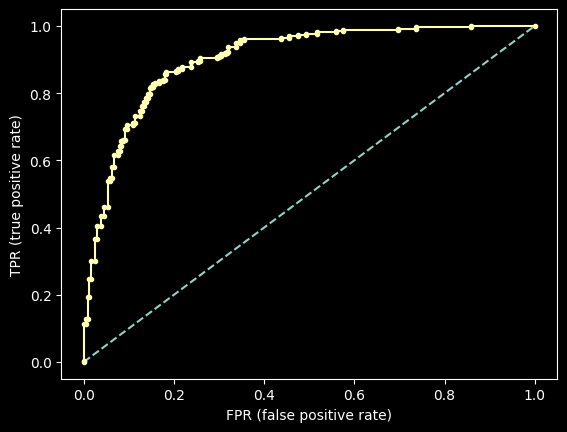

In [8]:
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr, marker=".")
plt.xlabel("FPR (false positive rate)")
plt.ylabel("TPR (true positive rate)")
plt.show()


Поскольку кривая выше разделительно уровня, модель лучше случайной

Если обычно берется разделение >0.5, <0.5, то roc кривая перебирает значения от 0 до 1 и подставляет значения для разделения по другому порогу, и для каждого считает количество верно и ошибочно 

---
Используем метрику ROC-AUC, измеряющуя площадь под графиком данной кривой

In [9]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.9027724358974359

В данном случае, мы имеем значение примерно в 90,3%, что можно интерпретировать как общее качество модели вне зависимости от выбранного порога.

Давайте по аналогии построим график PR-кривой. Из лекции мы знаем, что он строится по аналогичному признаку, но в других координатах.

In [10]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])

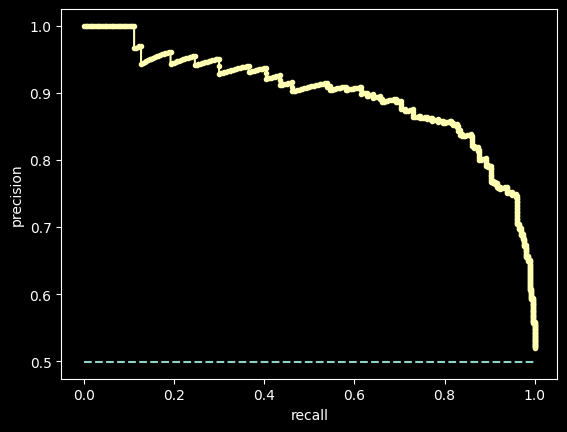

In [11]:
no_skill = len(y[y == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")

plt.plot(recall, precision, marker=".")
plt.xlabel("recall")  # Отзывчивость
plt.ylabel("precision")  # Точность
plt.show()


Площадь под кривой

In [12]:
auc(recall, precision)

0.897662372903334

Построим отчет о классификации модели (с порогом 0.5)

In [13]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.83      0.82      0.83       240
           1       0.84      0.85      0.84       260

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



Построим модель методом ближайших соседей

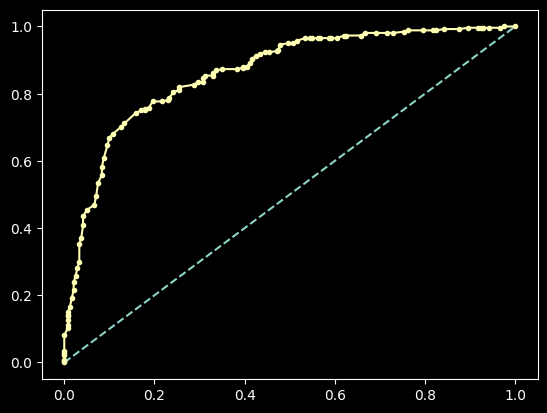

In [14]:
model2 = KNeighborsClassifier(n_neighbors=250).fit(X_train, y_train)
y_pred2_proba = model2.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred2_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr, marker=".")
plt.show()


## Дизбаланс классов

Наиболее явно различия между этими двумя классификационными кривыми - ROC и PR - демонстрирует пример с большим дизбалансом классов.

In [15]:

X, y = make_classification(
    n_samples=1000, n_classes=2, weights=[0.99, 0.01], random_state=1
)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=4)

print("Датасет: Class0=%d, Class1=%d" % (len(y[y == 0]), len(y[y == 1])))
print(
    "Обучающая: Class0=%d, Class1=%d"
    % (len(y_train[y_train == 0]), len(y_train[y_train == 1]))
)
print(
    "Тестовая: Class0=%d, Class1=%d"
    % (len(y_test[y_test == 0]), len(y_test[y_test == 1]))
)


Датасет: Class0=985, Class1=15
Обучающая: Class0=490, Class1=10
Тестовая: Class0=495, Class1=5


Видно, что в одной половине выборки положительных объектов в два раза больше, чем в другой. Прислучайном разделении, если есть сильно миноритарные классы, может случиться и не такое. Например, мы можем случайно получить выборку, в которой какие-то классы не представлены вообще. Для предотвращения таких случаев нужно воспользоваться стратификацией:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
print("Датасет: Class0=%d, Class1=%d" % (len(y[y == 0]), len(y[y == 1])))
print(
    "Обучающая: Class0=%d, Class1=%d"
    % (len(y_train[y_train == 0]), len(y_train[y_train == 1]))
)
print(
    "Тестовая: Class0=%d, Class1=%d"
    % (len(y_test[y_test == 0]), len(y_test[y_test == 1]))
)


Датасет: Class0=985, Class1=15
Обучающая: Class0=492, Class1=8
Тестовая: Class0=493, Class1=7


In [18]:
model = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)


Сразу познакомимся с дефолтным поведением модели, построив отчет о классификации:

In [19]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       493
           1       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



c:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Здесь мы видим классическую картину обучения на неравномерной выборке. Мажоритарный класс (в данном случае - отрицательный, он у нас в большинстве) распознается очень хорошо, а миноритарный - очень плохо. В нашем случае, вообще по положительному классу все метрики нулевые. Но обратите внимание, что общая точность (accuracy) модели весьма приемлема - 98%. Дизбаланс классов "скрывает" в точности недостатки работы модели.

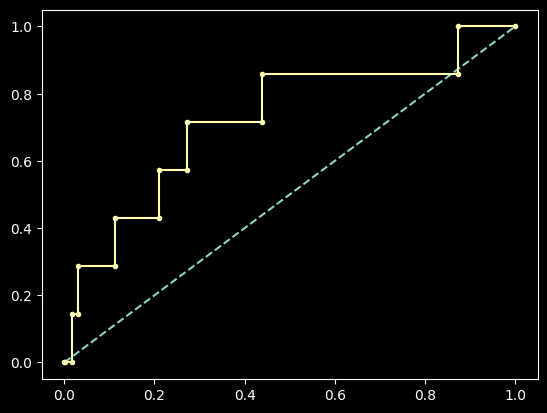

In [20]:
# ROC кривая
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr, marker=".")
plt.show()


Мы видим. что вривая показывает не идеальное, но вполне примелемое поведение модели. Средняя точность будет, несомненно, ниже, чем в первом примере работы, но ничего катастрофического мы здесь не наблюдаем. Но давайте построим кривую PR:

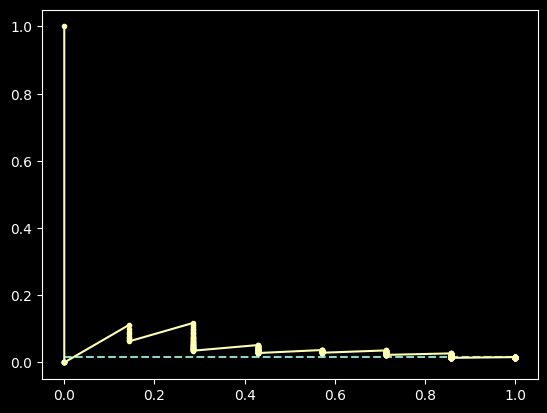

In [21]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
no_skill = len(y[y == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")
plt.plot(recall, precision, marker=".")
plt.show()

И вот на этом графике уже открывается истинное поведение модели: она не очень-то отличается от тривиальной, просто чаще предсказывает самый распространенный класс. Так как метрики Precision и Recall специально были созданы для случая несбалансированных классов, именно PR-кривая дает более реалистические оценки эффективности работы моделей классификации на таких данных, где наблюдается большой дисбаланс классов.

## Выбор значения порога по кривым
Кривые классификации, несомненно, удобный и визуальный способ представления эффективности работы моделей машинного обучения. Но главная их ценность состоит в том, что данные, которые необходимы для их построения могут использоваться для оптимизации порога классификации. Мы уже поняли, что разные значения порога могут приводить к разному поведению моделей и, как следствие, к имзенению метрик. Значит, можно выбрать такой порог, который дает более точную классификацию?

Да, но для этого нам понадобится некоторый критерий - численное значение, которые мы хотим оптимизировать. В лекции мы уже говорили, что простые метрики - precision, recall, accuracy - не очень подходят на роль критерия оптимизации. Но мы можем использовать, например, метрику F1 (и любые метрики из F-семейства). Для этого еще раз сгенерируем датасет, сделаем чуть больше объем данных:

In [22]:
X, y = make_classification(
    n_samples=10000, n_classes=2, weights=[0.99, 0.01], random_state=1
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

model = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)


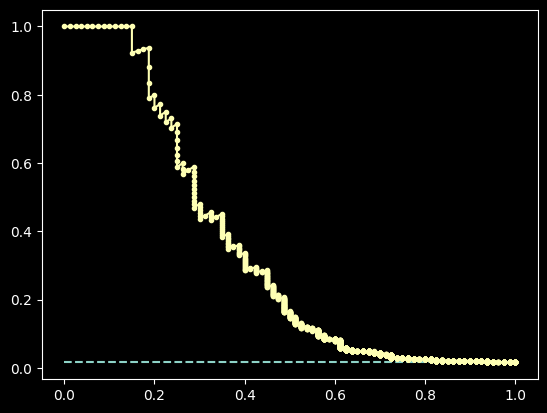

In [23]:
p, r, pr_thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
no_skill = len(y[y == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")
plt.plot(r, p, marker=".")
plt.show()


По точкам на ней мы видим, что при разных значениях порога иногда метрика precision будет больше, иногда - recall. Именно поэтому мы будем оптимизировать по метрике F1. Для этого импортируем из бибилиотеки numpy функцию argmax:

Вычислим вектор метрик F1 при всех использованных значениях порога и найдем самое большое значение среди них (вернее, его индекс):

In [24]:
f1 = (2 * p * r) / (p + r)
ix = np.argmax(f1)
pr_thresholds[ix]


0.12622727682487764

Так как индексы всех массивов, возвращенных функцией precision_recall_curve соответственны, по этому индексу получим значение порога и соответствующее ему значение метрики F1:

In [25]:
print("Порог=%f, F-Score=%.3f" % (pr_thresholds[ix], f1[ix]))

Порог=0.126227, F-Score=0.394


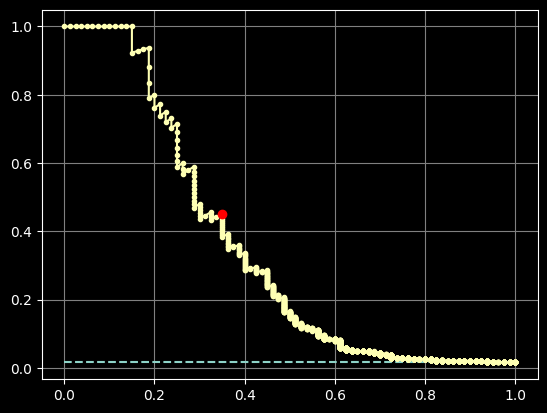

In [26]:
plt.grid(color='grey', zorder=1)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")
plt.plot(r, p, marker=".", zorder=2)
plt.scatter(r[ix], p[ix], marker="o", color="red", zorder=3)
plt.show()


Обратите внимание, что мы использовали метрику F1 - это среднее геометрическое между Precision и Recall. При этом эти две метрики имеют равный вклад в среднее. Бывают ситуации, когда нам более приоритетна одна из этих двух метрик. Тогда следует использоваться параметрическую метрику из F-семейства. Мы можем придать в среднем разный вес, то есть больше предпочесть recall или, наоборот, precision.



Давайте используем данное значение порога для проведение непосредственной классификации. Раньше мы так не делали, так как всегда использовали метод predict, который всегда использует порог по умолчанию - 0,5. Но точечная классификация - это не что иное, как выбор положительного класса, если модель оценивает вероятность принадлежности к нему выше порога:

In [27]:
y_pred = (y_pred_proba[:, 1] > pr_thresholds[ix]).astype("int")

Сравнение отчетов

In [28]:
# Наш порог
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4920
           1       0.44      0.34      0.38        80

    accuracy                           0.98      5000
   macro avg       0.72      0.67      0.69      5000
weighted avg       0.98      0.98      0.98      5000



In [29]:
# Порог по умолчанию
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4920
           1       0.92      0.15      0.26        80

    accuracy                           0.99      5000
   macro avg       0.95      0.57      0.63      5000
weighted avg       0.99      0.99      0.98      5000



## Задания для самостоятельного выполнения

---
### Повторите анализ из лабораторной работы, но с двумерными датасетами. Изобразите графически, как изменение порога влияет на расположение границы принятия решений.

In [30]:
X, y = make_classification(
    n_samples=1000,
    n_classes=2,
    random_state=1,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    class_sep=1.5
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [31]:
model = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)


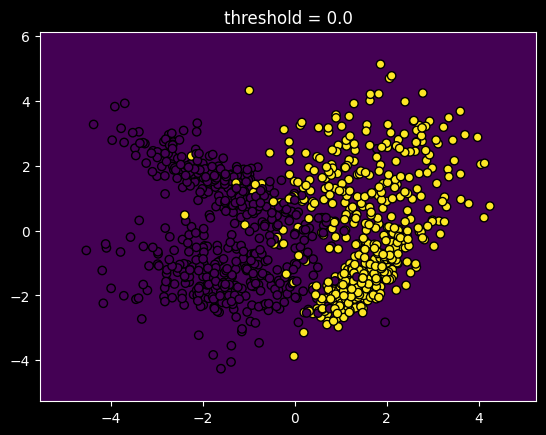

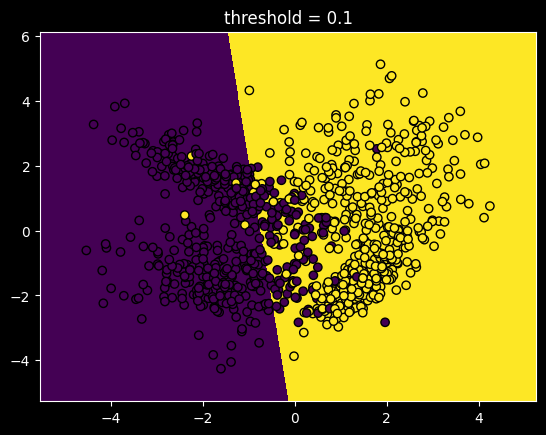

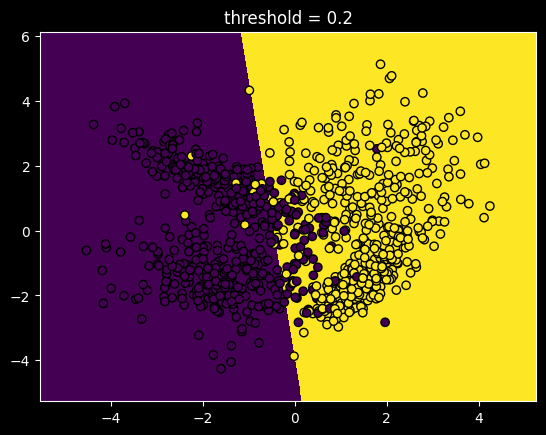

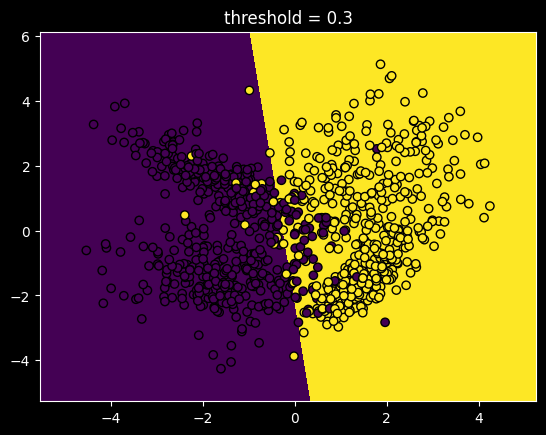

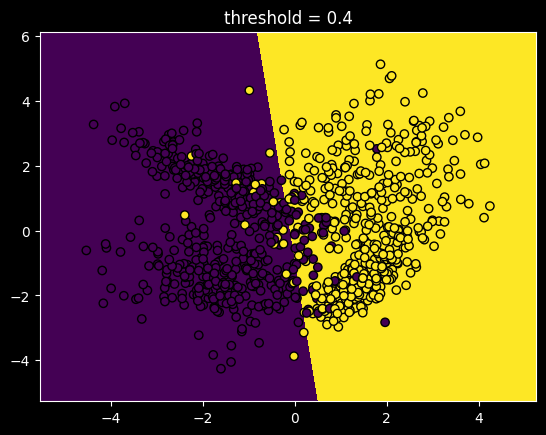

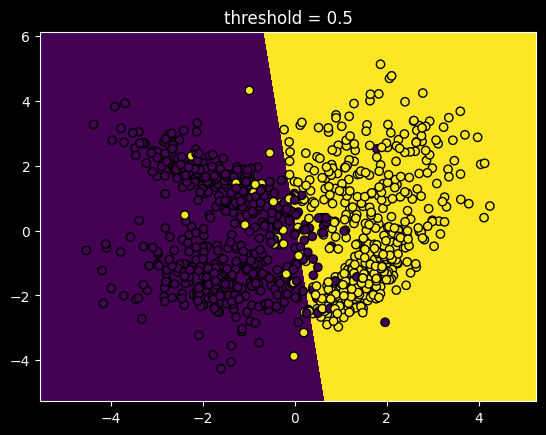

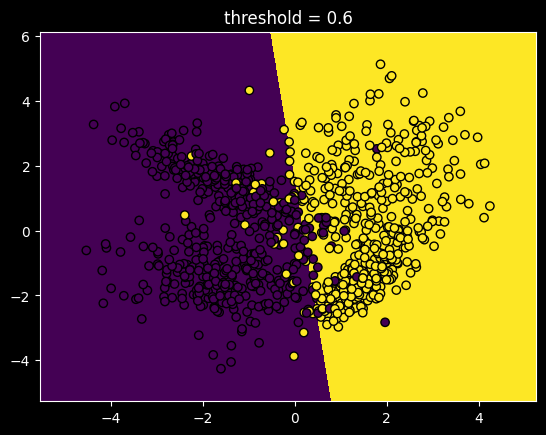

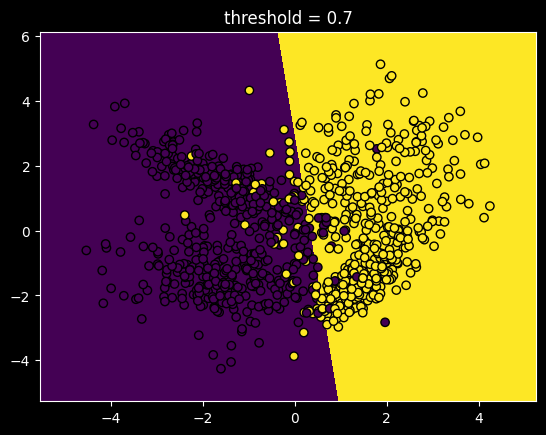

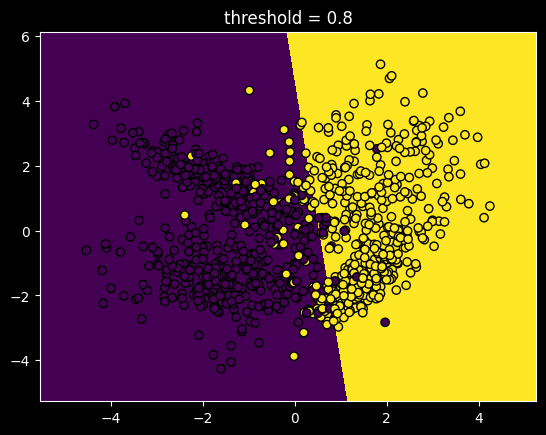

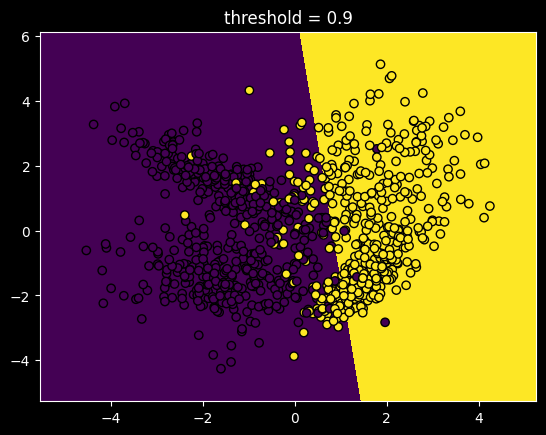

In [32]:
X0 = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, X.shape[0])
X1 = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, X.shape[0])
X0_grid, X1_grid = np.meshgrid(X0, X1)

y_predict = (
    model.predict_proba(np.c_[X0_grid.ravel(), X1_grid.ravel()])[:, 1]
).reshape(X0_grid.shape)
for threshold in np.arange(0, 1, 0.1):
    plt.pcolormesh(X0_grid, X1_grid, y_predict > threshold)
    plt.title(f"{threshold = :.1f}")
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="black", linewidth=1)
    plt.show()


---
### Повторите анализ на реальном датасете для бинарной классификации. Проинтерпретируйте результат, сделайте вывод.


In [54]:
# Сделаем из wine датасет для бинарной классификации
dataset = load_wine()
y = dataset.target
X = pd.DataFrame(dataset.data[y != 2])
y = pd.Series(y[y != 2])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y)

In [75]:
model_wine = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model_wine.predict_proba(X)


c:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


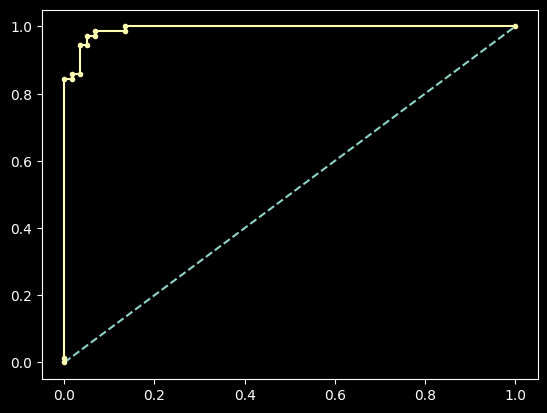

0.9925996657913583

In [76]:
# ROC кривая
fpr, tpr, roc_threshold = roc_curve(y, y_pred_proba[:, 1])
# fpr, tpr, _ = roc_curve(y, model_wine.predict_proba(X)[:, 1])

plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr, marker=".")
plt.show()
roc_auc_score(y, y_pred_proba[:, 1])


Модель получилась хорошей точность, с высоким TPR при низком FPR

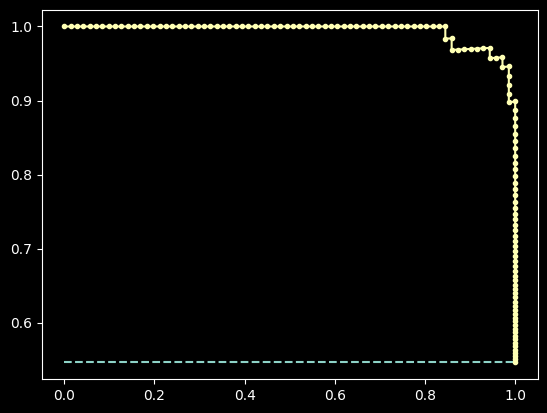

0.9938159654246812

In [77]:
# PR Кривая
precision, recall, pr_threshold = precision_recall_curve(y, y_pred_proba[:, 1])
no_skill = len(y[y == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--")
plt.plot(recall, precision, marker=".")
plt.show()
auc(recall, precision)


высокая точность и отзывчивость

---
### В задании по оптимизации порога используйте ROC и среднее геометрическое между TPR и FPR как критерий оптимизации.


In [84]:
roc_threshold[ind := np.argmax(gmean((tpr, 1-fpr)))]

0.5494240475807286

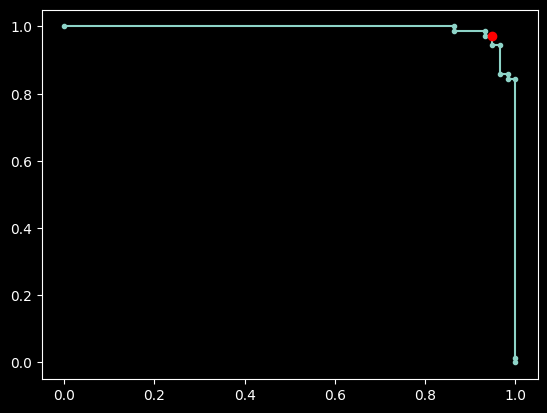

In [88]:
plt.plot(1 - fpr, tpr, marker=".", zorder=0)
plt.scatter((1 - fpr)[ind], tpr[ind], marker="o", c="r", zorder=1)

`fpt` заменено на `1-fpt` тк `gmean` ищет точку ближаюйшую к правому а не левому верхнему углу

---
### При оптимизации порога по PR-кривой используйте другую F-метрику - сначала с преимуществом precision, а затем - с превалированием recall. Изобразите получившиеся пороги на графике. Проанализируйте метрики получившихся моделей.


Если β>1, это увеличит вес precision, делая F-метрику более чувствительной к precision.

Если β<1, это увеличит вес recall, делая F-метрику более чувствительной к recall.


In [90]:
# Порог по умолчанию
print(classification_report(y, y_pred_proba[:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        59
           1       0.96      0.97      0.97        71

    accuracy                           0.96       130
   macro avg       0.96      0.96      0.96       130
weighted avg       0.96      0.96      0.96       130



In [93]:
# Преимущество precision
b = 2
f1 = ((b**2 + 1) * precision * recall) / (b**2 * precision + recall)
ix = np.argmax(f1)
print(pr_threshold[ix])
print(classification_report(y, y_pred_proba[:, 1] > pr_threshold[ix]))


0.18816155044853916
              precision    recall  f1-score   support

           0       0.98      0.86      0.92        59
           1       0.90      0.99      0.94        71

    accuracy                           0.93       130
   macro avg       0.94      0.93      0.93       130
weighted avg       0.94      0.93      0.93       130



In [94]:
# Преимущество recall
b = 0.5
f1 = ((b**2 + 1) * precision * recall) / (b**2 * precision + recall)
ix = np.argmax(f1)
print(pr_threshold[ix])
print(classification_report(y, y_pred_proba[:, 1] > pr_threshold[ix]))


0.6057319842048218
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        59
           1       0.97      0.93      0.95        71

    accuracy                           0.95       130
   macro avg       0.94      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130



---
### Постройте классификационные кривые для задачи множественной классификации. Проинтерпретируйте результат.


In [39]:
X = pd.DataFrame(dataset.data)
y = pd.Series(dataset.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [40]:
model_wine2 = KNeighborsClassifier().fit(X_train, y_train)
y_pred_proba = model_wine2.predict_proba(X_test)


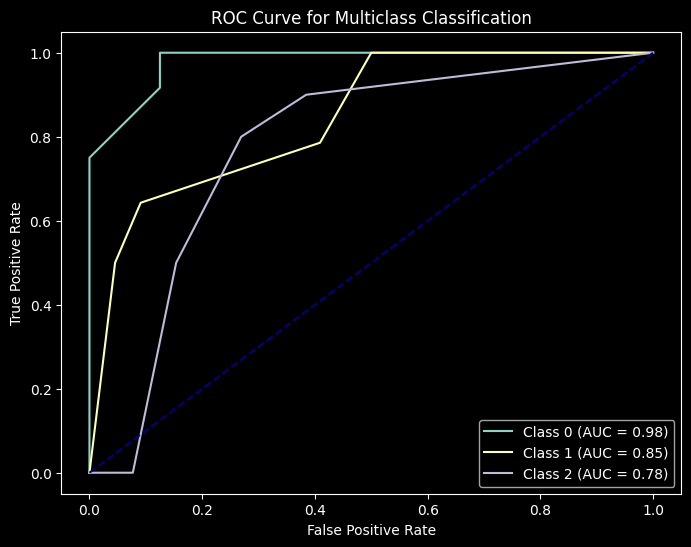

In [42]:
# Вычисление ROC-кривых и их площадей для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        y_test_bin[:, i], model_wine2.predict_proba(X_test)[:, i]
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение ROC-кривых
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass Classification")
plt.legend()
plt.show()


Хорошая модель достаточно высокой точность

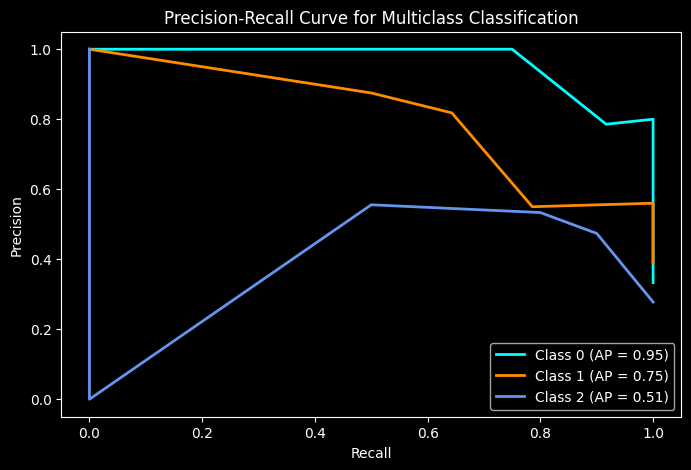

In [44]:
# Рассчитывание PR-кривой для каждого класса
precision = dict()
recall = dict()
average_precision = dict()
y_score = model_wine2.predict_proba(X_test)
for i in range(3):  # 3 - количество классов
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Строим PR-кривую
plt.figure(figsize=(8, 5))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(3), colors):
    plt.plot(
        recall[i],
        precision[i],
        color=color,
        lw=2,
        label=f"Class {i} (AP = {average_precision[i]:.2f})",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Multiclass Classification")
plt.legend(loc="lower right")
plt.show()


---
### Используйте для построения кривых библиотеку yellowbrick.

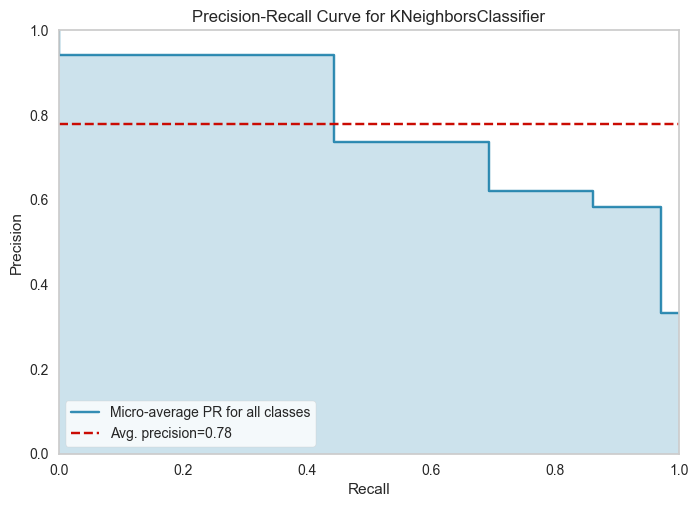

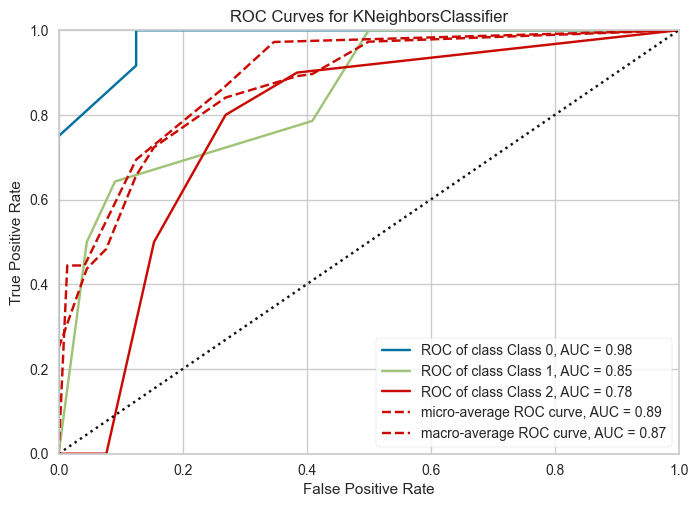

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [47]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve


# PR кривая
prc_visualizer = PrecisionRecallCurve(
    model_wine2, classes=["Class 0", "Class 1", "Class 2"]
)
prc_visualizer.fit(X_train, y_train)
prc_visualizer.score(X_test, y_test)
prc_visualizer.show()

# ROC кривая
roc_visualizer = ROCAUC(model_wine2, classes=["Class 0", "Class 1", "Class 2"])
roc_visualizer.fit(X_train, y_train)
roc_visualizer.fit(X_train, y_train)
roc_visualizer.score(X_test, y_test)
roc_visualizer.show()


---
## Контрольные вопросы



- Какие модели можно оценивать с помощью классификационных кривых (ROC и PR) и почему именно их?
- В каких случаях лучше использовать PR-кривую, а в каких - ROC и почему?
- Какие виды усреднения вы знаете (micro, macro) и в чем особенности их применения?
- Как вычисляются метрики для построения кривых в задачах множественной классификации?
- Почему при построении кривых с помощью yellowbrick на графике отображаются сразу несколько кривых и что они значат?
- Дополнительные задания
- На реальном датасете для бинарной классификации используйте кривые для сравнения нескольких видов моделей между собой (изобразите кривые разных моделей на одном графике). Сделайте вывод о том, какая модель будет лучше работать с учетом оптимизации порога.
- Повторите предыдущее задание, но для задачи множественной классификации. Выберите два датасета: один с относительно равным распределением классов, а второй - с близким к экспоненциальному, с большим неравенством классов. Продемонтрируйте разницу в поведении моделей на разных кривых.